In this notebook we're going to use YOLO in order to have a model who can detect the object present in an image

# Installation of dependencies we'll need

In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
%pip install -qr requirements.txt 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu
Cloning into 'yolov5'...
remote: Enumerating objects: 14997, done.
remote: Total 14997 (delta 0), reused 0 (delta 0), pack-reused 14997
Receiving objects: 100% (14997/14997), 13.95 MiB | 10.61 MiB/s, done.
Resolving deltas: 100% (10304/10304), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.2 MB/s eta 0:00:00


# Import all libraries we'll need

In [2]:
import torch
import utils
from models.experimental import attempt_load
import models.yolo
from utils.general import scale_boxes, non_max_suppression, xyxy2xywh, LOGGER
from utils.augmentations import letterbox
from utils.plots import Annotator, colors, save_one_box
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  
import thop
from utils.torch_utils import time_sync

# Instantiate a YOLO model

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
coco2017_folder = '/content/gdrive/MyDrive/3A/Github/lab_8_yolo/images'
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-69-g3b6e27a Python-3.8.16 torch-1.13.0+cu116 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.1/107.7 GB disk)


In [7]:
model = attempt_load('yolov5s.pt')

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


# Lets check what YOLO look like :

In [8]:
def _profile_one_layer(m, x):
    """
    this function evaluate the modul m with x as an entry,
    it returns the number of parameters and the time of execution
    """
    o = thop.profile(m, inputs=(x.copy() if isinstance(m, models.yolo.Detect) else x,), verbose=False)[0] / 1E9 * 2  # FLOPs
    t = time_sync()
    for _ in range(10):
        m(x.copy() if isinstance(m, models.yolo.Detect) else x)
    return o, (time_sync() - t) * 100

imgsz=(1, 3, 640, 640)
x = torch.zeros(*imgsz, device='cpu')
y,  flops, nps  = [], [], []  # outputs
LOGGER.info("{:<10} {:<10} {:<10} {:<40} {:<40}".format('time (ms)','GFLOPs','params','module', 'input shape'))
for i, m in enumerate(model.model):
    if m.f != -1:  # Si la sortie requise n'est pas simplement la couche précédente. 
        x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # récupérer les couches précédente
    # obtenir la taille d'entrée de ce module
    input_shape = [tuple(xx.shape[1:]) for xx in x] if isinstance(x,list) else tuple(x.shape[1:]
                                                                                    )
    o, dt = _profile_one_layer(m, x)
    x = m(x)  # run
    # sauvegarder la sortie pour d'éventuelles futurs connections résiduelles 
    y.append(x if m.i in model.save else None)
    LOGGER.info("{:<10.2f} {:<10.2f} {:<10.2f} {:<40} {:<40}".format(dt,o,m.np,m.type, str(input_shape)))    

time (ms)  GFLOPs     params     module                                   input shape                             
20.70      0.71       3520.00    models.common.Conv                       (3, 640, 640)                           
21.78      0.94       18560.00   models.common.Conv                       (32, 320, 320)                          
35.85      0.94       18816.00   models.common.C3                         (64, 160, 160)                          
17.27      0.94       73984.00   models.common.Conv                       (64, 160, 160)                          
34.88      1.47       115712.00  models.common.C3                         (128, 80, 80)                           
18.84      0.94       295424.00  models.common.Conv                       (128, 80, 80)                           
39.88      1.99       625152.00  models.common.C3                         (256, 40, 40)                           
16.61      0.94       1180672.00 models.common.Conv                       (256, 

# Use the model

## First with a basic image :

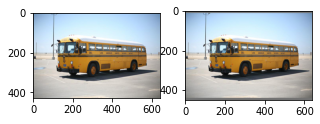

In [14]:
im = imread(coco2017_folder + '/000000000471.jpg')
imr = letterbox(im)[0]
f, ax = plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(im)
ax[1].imshow(imr)
plt.show()

In [15]:
#Here is the prediction of the model :

pytorch_im = torch.from_numpy(imr).to('cpu').float()
pytorch_im /= 255  # 0 - 255 to 0.0 - 1.0
if len(pytorch_im.shape) == 3:
    pytorch_im = pytorch_im[None]  # expand for batch dim
pred = model(pytorch_im.permute(0,3,1,2))
pred[0].shape, pred[1][0].shape, pred[1][1].shape, pred[1][2].shape

(torch.Size([1, 17640, 85]),
 torch.Size([1, 3, 56, 80, 85]),
 torch.Size([1, 3, 28, 40, 85]),
 torch.Size([1, 3, 14, 20, 85]))

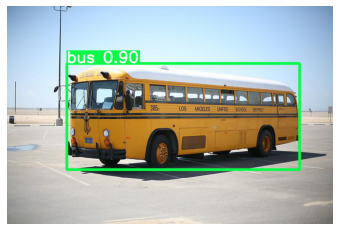

In [16]:
#Lets print the prediction on the image

# First we only keep the valid prediction:
predictions = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, max_det=300)[0]

# Here we just use the good format for the prediction

annotator = Annotator(im, line_width=3, example=str(model.names))
predictions[:, :4] = scale_boxes(pytorch_im.shape[1:3], predictions[:, :4], im.shape).round()
for *xyxy, conf, cls in reversed(predictions):
    gn = torch.tensor(im.shape)[[2, 1, 2, 1]]# whwh
    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()
    label = f'{model.names[int(cls)]} {conf:.2f}'
    annotator.box_label(xyxy, label, color=colors(int(cls), True))
im0 = annotator.result()
plt.imshow(im0)
plt.axis('off')
plt.show()

the model is 90% sure that there is a bus in the image

## Now with multiple image :

In [19]:
# This is the function to predict on multiple image :

def predict(im):
    im = letterbox(im)[0]
    pytorch_im = torch.from_numpy(im).to('cpu').float()
    pytorch_im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(pytorch_im.shape) == 3:
        pytorch_im = pytorch_im[None]  # expand for batch dim
    pred = model(pytorch_im.permute(0,3,1,2))
    predictions = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, max_det=300)[0]
    annotator = Annotator(im, line_width=3, example=str(model.names))
    predictions[:, :4] = scale_boxes(pytorch_im.shape[1:3], predictions[:, :4], im.shape).round()
    for *xyxy, conf, cls in reversed(predictions):
        gn = torch.tensor(im.shape)[[2, 1, 2, 1]]# whwh
        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()
        label = f'{model.names[int(cls)]} {conf:.2f}'
        annotator.box_label(xyxy, label, color=colors(int(cls), True))
    return annotator.result()

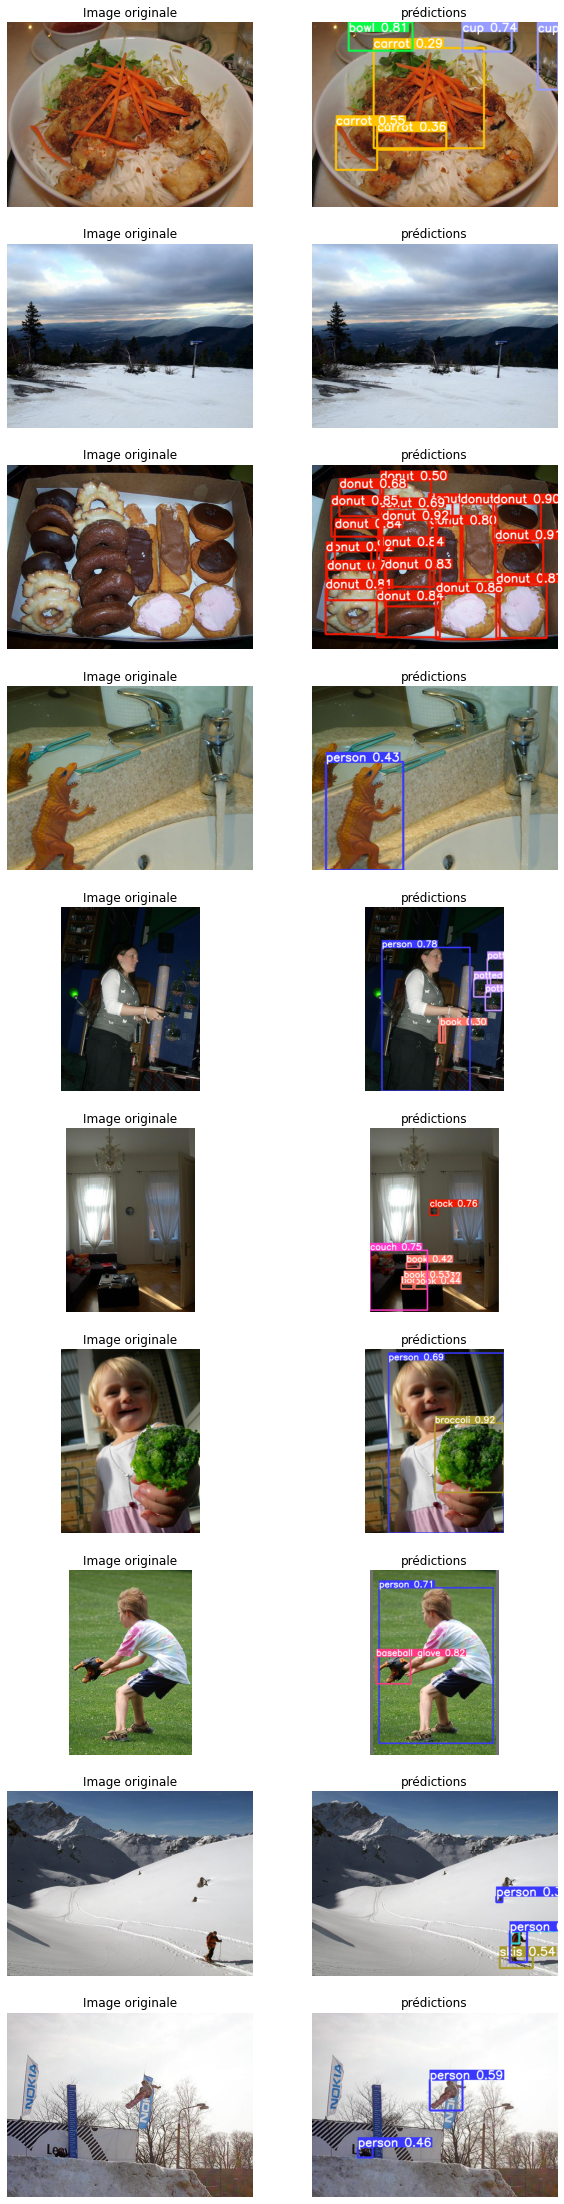

In [20]:
import glob
imgs = glob.glob(coco2017_folder + '/*.jpg')
imgnum = 10
fig, axs =plt.subplots(imgnum,2,figsize=(10,40))
for i,path in enumerate(imgs[:imgnum]):
    im = imread(path)
    axs[i,0].set_title('Image originale')
    axs[i,0].imshow(im)
    axs[i,0].axis('off')
    results = predict(im)
    axs[i,1].imshow(results)
    axs[i,1].set_title('prédictions')
    axs[i,1].axis('off')
plt.show()

We can notice that the model has good prediction overall, but there is still some problems. For example he detects multiple donuts instead of juste detecting a group of donuts (same for the carrots). It also has problem with landscape.